In [225]:
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
sym.init_printing(use_latex="mathjax")
from scipy.optimize import root

In [226]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300.0
mumax=1.2
romax=0.2
m=15.0
qmax=0.04
qmin=0.004
h=120.0
d=10.0


delta_z = 0.01
zmax = 50.0
N = int(zmax/delta_z)
z = np.linspace(0,zmax,N)   

A1_guess = 100.0                 #100
Rb1_guess = 2.2                  #5 * ( qmin * A1_guess )
Rd1_guess = 30.0                 #89.33333333333

A1,Rb1,Rd1 = sym.symbols('A1 Rb1 Rd1')


In [227]:
def q(Rb, A):
    return Rb/A
    
def p(I,q, mumax=mumax, qmin=qmin, h=h):
    return mumax * (1 - qmin/q) * (I/(h + I))

def ro(q, Rd, romax = romax, qmax = qmax, qmin=qmin, m=m):
    return romax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [228]:
def plankton_equations(z,y):
    
    A1 = y[0]
    A2 = y[1]
    Rb1 = y[2]
    Rb2 = y[3]
    Rd1 = y[4]
    Rd2 = y[5]
    I = y[6]
    q = Rb1/A1
    
    derivatives = np.array((-A2,
                     (-v*A2 + lbg*A1 - p(I,q)*A1)/d,
                     -Rb2,
                     (-v*Rb2 + lbg*Rb1 - ro(q,Rd1)*A1)/d,
                     -Rd2,
                     (ro(q,Rd1)*A1 - lbg*Rb1)/d,
                     -(k*A1 + kbg)*I))
    return derivatives

initial_conditions = np.array([A1_guess,
                              -v*A1_guess/d,
                              Rb1_guess,
                              -v*Rb1_guess/d,
                              Rd1_guess,
                              0,
                              I0])

In [229]:
one_step_rk4(plankton_equations,0.0,initial_conditions,zmax,N)

array([100.02529738,  99.94053804, 100.00058216,  99.99356711,
        99.99996776, 100.00644745,  98.71275824])

In [230]:
def one_step_rk4(f, z, xvinit, Tmax, N):
    xv = xvinit                            # set first ROW to the initial conditions
    h = Tmax / N                           # step size
    
    k1 = f(z,xv)
    k2 = f(z,xv + h/2.0*k1)
    k3 = f(z,xv + h/2.0*k2)
    k4 = f(z,xv + h*k3)
    
    next_step = xv[0] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
    
    return next_step

In [231]:
def rk4(f, z0, xvinit, Tmax, N):               # N=number of steps
    T = np.linspace(z0, Tmax, N+1)
    xv = np.zeros( (len(T), len(xvinit)) ) # matrix with # cols=# initial conditions
    xv[0] = xvinit                         # set first ROW = initial conditions
    h = Tmax / N                           # step size
    
    for i in range(N):
        k1 = f(T[i],xv[i])
        k2 = f(T[i],xv[i] + h/2.0*k1)
        k3 = f(T[i],xv[i] + h/2.0*k2)
        k4 = f(T[i],xv[i] + h*k3)
        xv[i+1] = xv[i] + h/6.0 *( k1 + 2*k2 + 2*k3 + k4)
        
    return T, xv

In [232]:
# To see how first 2 steps behave
#first_step = one_step_rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
#second_step = one_step_rk4(lambda x: plankton_equations(x), first_step, zmax, N)
first_step = one_step_rk4(plankton_equations,0.0, initial_conditions, zmax, N)
second_step = one_step_rk4(plankton_equations,0.0 + delta_z, initial_conditions, zmax, N)

In [233]:
#z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
z, derivs = rk4(plankton_equations,0.0, initial_conditions, zmax, N)

In [234]:
results = pd.DataFrame(derivs)
results.columns = ['A1','A2','Rb1','Rb2','Rd1','Rd2','I']
results = results.set_index(z)
results.index.name = 'z'
results['R'] = results.loc[:,['Rb1','Rd1']].sum(axis=1)
results['q'] = q(np.array(results.Rb1),np.array(results.A1))
results['ro'] = ro(np.array(results.q), np.array(results.Rd1))
results['p'] = p(np.array(results.I),np.array(results.q))

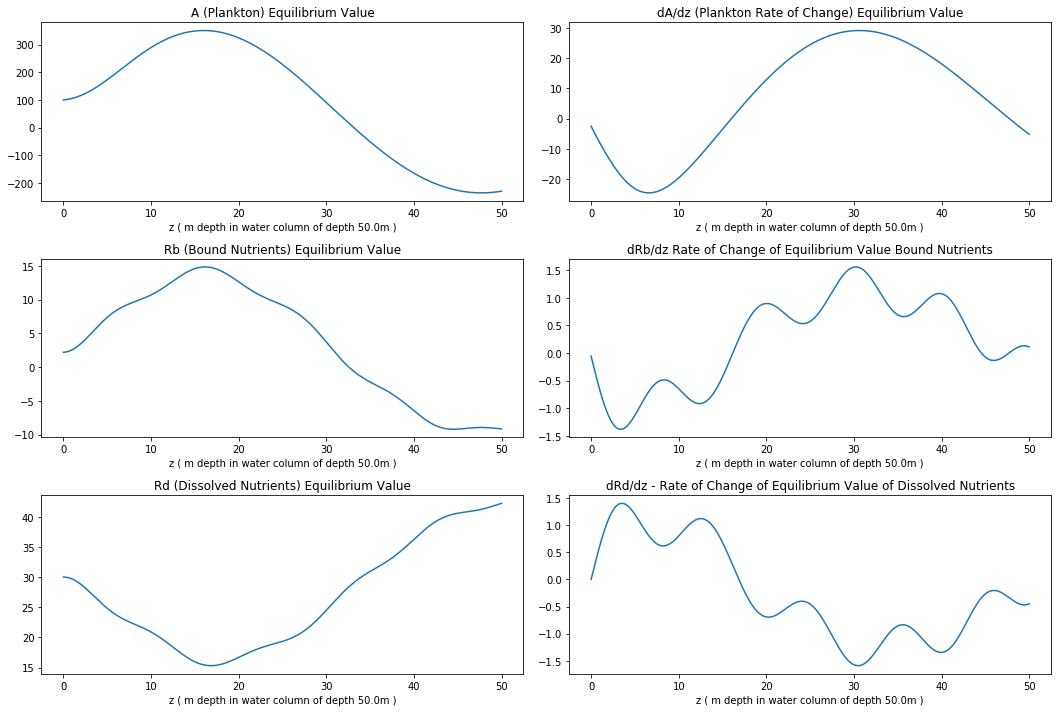

In [235]:
fig, axs = plt.subplots(3,2, figsize=(15,10))

axs[0,0].plot(results.A1)
axs[0,0].set_title('A (Plankton) Equilibrium Value')
axs[0,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[0,1].plot(results.A2)
axs[0,1].set_title('dA/dz (Plankton Rate of Change) Equilibrium Value')
axs[0,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,0].plot(results.Rb1)
axs[1,0].set_title('Rb (Bound Nutrients) Equilibrium Value')
axs[1,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[1,1].plot(results.Rb2)
axs[1,1].set_title('dRb/dz Rate of Change of Equilibrium Value Bound Nutrients')
axs[1,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,0].plot(results.Rd1)
axs[2,0].set_title('Rd (Dissolved Nutrients) Equilibrium Value')
axs[2,0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

axs[2,1].plot(results.Rd2)
axs[2,1].set_title('dRd/dz - Rate of Change of Equilibrium Value of Dissolved Nutrients')
axs[2,1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

plt.tight_layout()

Text(0.5, 0, 'z ( m depth in water column of depth 50.0m )')

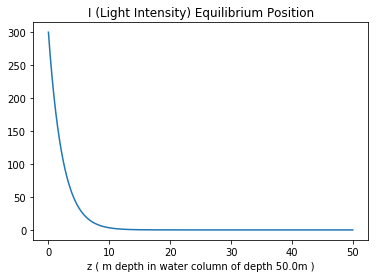

In [236]:
plt.plot(results.I)
plt.title('I (Light Intensity) Equilibrium Position')
plt.xlabel('z ( m depth in water column of depth {}m )'.format(zmax))

In [146]:
results.tail()

,A1,A2,Rb1,Rb2,Rd1,Rd2,I,R,q,ro,p
z,,,,,,,,,,,
49.96,-128.372932,-8.112094,-5.197984,0.031471,40.694970,-0.271420,2.693669e-215,35.496986,0.040491,-0.001994,2.427570e-217
49.97,-128.291757,-8.122898,-5.198295,0.030680,40.697681,-0.270637,2.206598e-215,35.499386,0.040519,-0.002108,1.988767e-217
49.98,-128.210474,-8.133691,-5.198598,0.029875,40.700383,-0.269840,1.807528e-215,35.501785,0.040547,-0.002222,1.629215e-217
49.99,-128.129083,-8.144473,-5.198892,0.029055,40.703077,-0.269028,1.480571e-215,35.504185,0.040575,-0.002336,1.334613e-217
50.00,-128.047584,-8.155244,-5.199179,0.028222,40.705764,-0.268201,1.212707e-215,35.506585,0.040603,-0.002450,1.093239e-217


### Plots of Functions ro, p and q

Text(0.5, 1.0, 'ro')

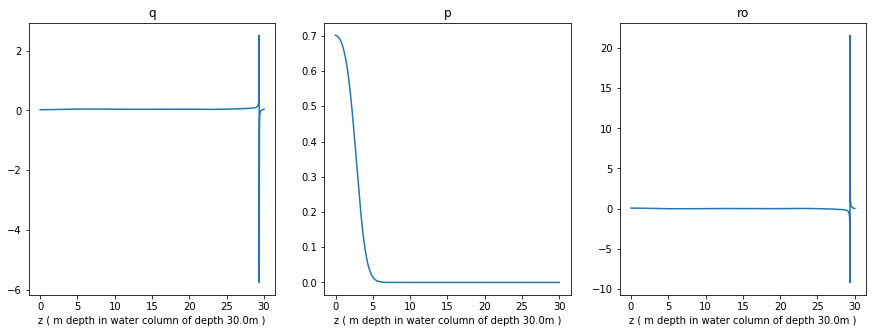

In [75]:
fig,axs = plt.subplots(1,3, figsize=(15,5) )

axs[0].plot(results.q)
axs[1].plot(results.p)
axs[2].plot(results.ro)
axs[0].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))
axs[1].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))
axs[2].set_xlabel('z ( m depth in water column of depth {}m )'.format(zmax))
axs[0].set_title('q')
axs[1].set_title('p')
axs[2].set_title('ro')

## For Shooting Method:

In [22]:
def end_values(values_at_zmax_integrated):
    """Creates Robin boundary conditions using values at zmax of integrated function and adds known BCs."""
    
    Rb1_end = values_at_zmax_integrated[1]
    Rd2_end = values_at_zmax_integrated[3]
    values_at_zmax = np.array([0,       # A2
                          d*Rd2_end/v,  # Rb1 Robin Boundary Condition - not sure if this is right way to go
                          0,            # Rb2
                          v*Rb1_end/d]) # Rd2 Robin Boundary Condition
    return values_at_zmax

def residuals(initial_conditions):
    """Takes initial guess array of length 7 and returns residuals array
    
    containing residuals for A2,Rb1,Rb2,Rd2 and padded with 3 zeroes."""
    
    z, derivs = rk4(lambda x: plankton_equations(x), initial_conditions, zmax, N)
    
    residuals = np.zeros(7)
    values_at_zmax_integrated = derivs[N,[2,3,4,6]]       # actual values of A2,Rb1,Rb2,Rd2 obtained through integration
    BCs_at_zmax = end_values(values_at_zmax_integrated)   # expected relationship between values with Robin BCs
    residuals[[2,3,4,6]] = BCs_at_zmax - values_at_zmax_integrated
    #print("values obtained: {}".format(values_at_zmax_integrated))
    #print("values expected: {}".format(BCs_at_zmax))
    
    return residuals

print(residuals(initial_conditions))

[Notes on method to use ](https://stackoverflow.com/questions/30636988/python-scipy-fsolve-mismatch-between-the-input-and-output-shape-of-the-func-a)

In [25]:
root_sol = root(residuals, initial_conditions, method='lm')
IC_shooting = root_sol['x']

In [38]:
pd.DataFrame(IC_shooting,index=['A1','A2','Rb1','Rb2','Rd1','Rd2','I'])

,0
A1,1.754412
A2,1.275424
Rb1,-0.464111
Rb2,0.263517
Rd1,19.189909
Rd2,0.385939
I,152.486945


    But Rd2 should be 0, I should be I0=300 and vA1-dA2 should be zero, only want to change values for A1,Rb1 and Rd1

In [31]:
initial_conditions

array([1.0e+02, 2.5e+00, 2.2e+00, 5.5e-02, 3.0e+01, 0.0e+00, 3.0e+02])

In [32]:
v*IC_shooting[0] - d*IC_shooting[1]

-12.315634173713677